In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import neo

import numpy as np
import pandas as pd

from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import FloatVector
from rpy2.robjects import pandas2ri
pandas2ri.activate()

import scipy.stats

from collections import Counter

import matplotlib.gridspec as gridspec

import os

from scipy import signal

In [2]:
def spiketrains_iterator(handler):
    for blk in handler.read(cascade=True, lazy=False):
        for seg in blk.segments:
            for st in seg.spiketrains:
                yield st.name, np.array(st)
                
def events_iterator(handler):
    for blk in handler.read(cascade=True, lazy=False):
        for seg in blk.segments:
            for st in seg.events:
                yield st.annotations['channel_name'], np.array(st)

In [3]:
def clever_split(arr, step):
    res = list()
    
    idx = 0
    for l in np.arange(0, arr[~0], step):
        curr = list()
        while(idx < len(arr) and arr[idx] < l + step):
            curr.append(arr[idx])
            idx += 1
        
        res.append(curr)
    
    return res

In [4]:
fname = '../neuro_data/pattern_data/All_cells.nex'
r = neo.io.NeuroExplorerIO(fname)

trials = list()

for idxst, (name, spikes) in enumerate(events_iterator(r)):
    if len(spikes) < 50:
        continue
        
    trials.append(spikes)

In [81]:
cost_hist = list()
bin_hist = list()

for bsize in np.linspace(min(isi), max(isi), 100):
    splitted = clever_split(spikes, bsize)
    
    hist = list()
    
    for spikes in trials:
        bins = np.arange(0, spikes[~0] + bsize, bsize)
        curr_hist, bins = np.histogram(spikes, bins)
        hist.append(curr_hist)
    
    hist = np.concatenate(hist)
        
    k = np.mean(hist)
    v = np.mean([(ki - k)**2 for ki in hist])
        
    cost = (2*k - v)/(bsize**2) 
    
#     print('k: {}, v: {}, cost: {}'.format(k, v, cost))
    
    cost_hist.append(cost)
    bin_hist.append(bsize)

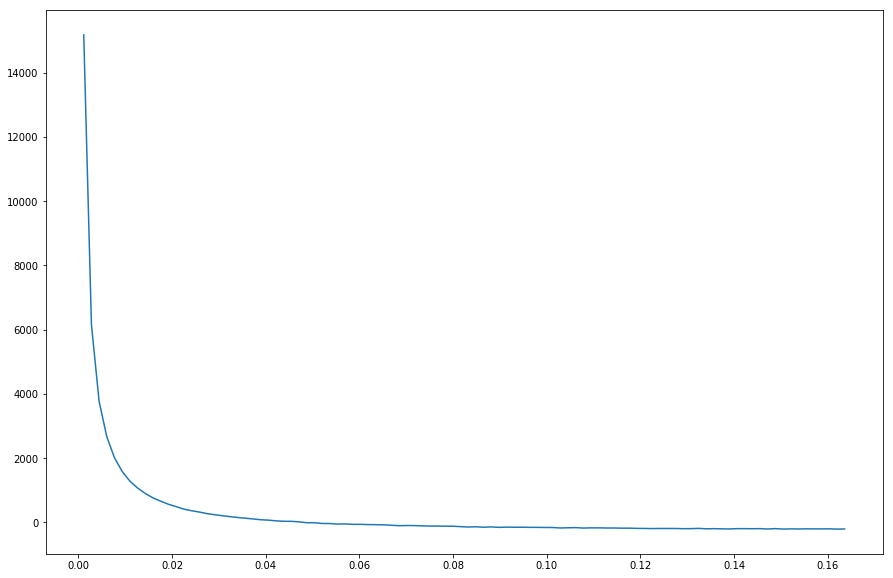

In [84]:
plt.figure(figsize=(15,10))
plt.plot(bin_hist, cost_hist)

In [87]:

def calc_lv(st):
    sp1 = st[:-2]
    sp2 = st[1:-1]
    sp3 = st[2:]
    
    return 3.*np.mean(np.power((sp3 - 2*sp2 + sp1)/(sp3 - sp1), 2))

def est_fano(count, fano):
    if count < 3:
        return 1.
    else:
        return fano

In [176]:
def calc_optimal(st):
    min_sp = np.min(st)
    max_sp = np.max(st)

    N = np.arange(2, 20000)
    D = (max_sp - min_sp)/N

    cost = np.zeros(N.shape[0])

    lv = calc_lv(st)

    for i in range(N.shape[0]):
        edges = np.linspace(min_sp, max_sp, N[i]+1)
        edges[0] = -np.inf
        edges[~0] = np.inf

        k, _ = np.histogram(st, edges)
        k = k[:N[i]]

        f = np.array([est_fano(ki, 2.0*lv/(3.0-lv)) for ki in k])
        cost[i] = (np.mean(2.*f*k) - np.var(k, ddof=1))/(D[i]**2)
        
    return N, cost

In [177]:
N, cost = calc_optimal(spikes)

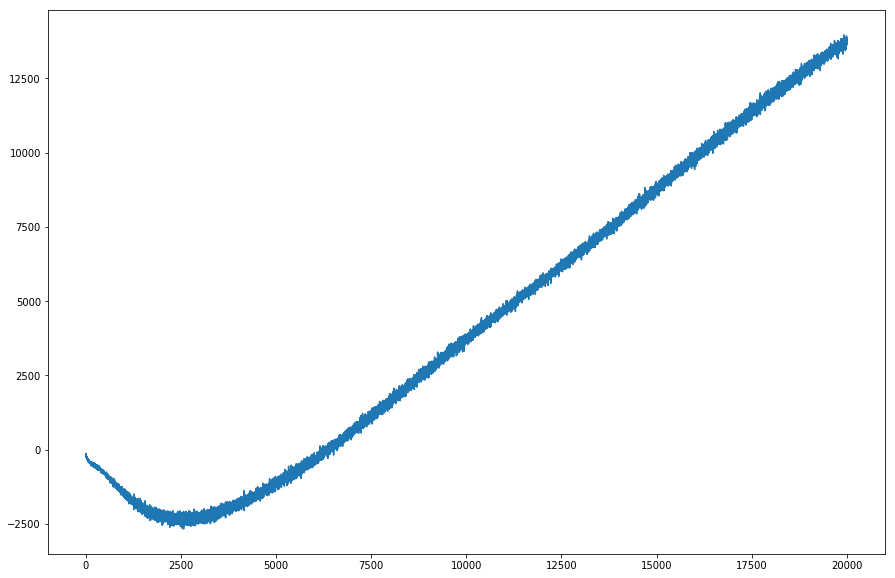

In [179]:
plt.figure(figsize=(15,10))
plt.plot(N, cost)

In [187]:
np.savetxt(fname='spikes.txt', X=spikes, newline=' ')

In [182]:
isi = spikes[1:] - spikes[:-1]

In [188]:
with open('spikes.txt', 'w') as out:
    for s in spikes:
        val = str(round(s, 3))
        out.write('{} '.format(val))

In [166]:
tst = '0.012 0.050 0.066 0.078 0.113 0.145 0.159 0.188 0.206 0.226 0.261 0.280 0.294 0.305 0.330 0.349 0.368 0.412 0.448 0.477 0.512 0.524 0.529 0.547 0.565 0.588 0.595 0.607 0.619 0.645 0.664 0.685 0.699 0.721 0.737 0.766 0.779 0.814 0.830 0.842 0.872 0.883 0.892 0.903 0.917 0.935 0.959 0.974 0.981 0.995 1.017 1.052 1.067 1.094 1.108 1.124 1.139 1.164 1.183 1.201 1.216 1.234 1.256 1.272 1.291 1.311 1.319 1.344 1.395 1.419 1.436 1.475 1.484 1.527 1.551 1.597 1.614 1.642 1.664 1.725 1.755 1.815 1.854 1.925 1.988 2.127 2.323 2.372 2.515 2.589 2.616 2.713 2.765 2.808 2.837 2.895 2.925 2.943 2.973 3.008 3.040 3.073 3.132 3.145 3.165 3.175 3.195 3.219 3.236 3.256 3.273 3.296 3.301 3.317 3.329 3.335 3.350 3.359 3.376 3.390 3.412 3.439'

In [172]:
data = np.array(list(map(float, tst.split())))

In [174]:
N, cost = calc_optimal(data)

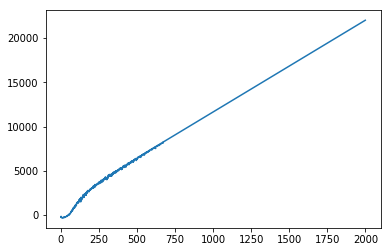

In [175]:
plt.plot(N, cost)

In [193]:
def OS(spike_times) :
    spike_times = np.array(spike_times)
    max_value   = max(spike_times)
    min_value   = min(spike_times)
    onset       = min_value - 0.001 * (max_value - min_value)
    offset      = max_value + 0.001 * (max_value - min_value)
    lv          = 0
    ISI         = np.diff(spike_times)

    # computes the firing irregularity Lv
 
    for i in range(0, len(spike_times) - 2) :
        interval1 = ISI[i]
        interval2 = ISI[i + 1]

        if(interval1 + interval2 != 0) :
            lv += 3 * pow(interval1 - interval2, 2) / (pow(interval1 + interval2, 2) * (len(spike_times) - 2))
        else :
            lv += 3 / (len(spike_times) - 2)

    # computes the cost function by changing the number of bins
    # adopts the number of bins that minimizes the cost function
    
    for bin_num in range(1, 5000) :
        times = 10
        cost = cost_av(spike_times, onset, offset, lv, bin_num, times)
        
        # updates the value if cost_min is vacant or the cost < cost_min        

        if (bin_num == 1 or cost < cost_min) :
            cost_min        = cost
            optimal_bin_num = bin_num

#     drawOS(spike_times, optimal_bin_num)
    return optimal_bin_num

########## 
# cost_f 
# computes the cost function defined by Omi and Shinomoto

# arguments:
# spike_times: spike train
# start: time of the initial spike
# end: time of the final spike
# lv: the value of local variation Lv, which measures the spiking irregularity 
# bin_num: number of bins

# returns the cost function
########## 


def cost_f(spike_times, start, end, lv, bin_num) :
    bin_width = (end - start) / bin_num
    hist = np.histogram(spike_times, np.linspace(start, end, bin_num + 1))[0]

    fano = 2.0 * lv / (3.0 - lv)

    av   = np.mean(hist)
    va   = np.mean(hist * hist)
    w_av = np.mean(hist * fano)
    fano_bin = np.where(hist > 2, fano, 1.0)

    return ((2.0 * np.mean(hist * fano_bin) - (va - av * av)) / (bin_width * bin_width))

########## 
# cost_av
# computes an average cost function with respect to initial binning positions.

# arguments:
# spike_times: spike train
# onset: time of an initial spike
# offset: time of a final spike
# lv: the value of local variation Lv, which measures the spiking irregularity
# bin_num: the number of bins
# times: the number of initial binning positions

# returns the averaged cost function
##########


def cost_av(spike_times, onset, offset, lv, bin_num, times) :
    temp = 0.0
    bin_width = (offset - onset) / bin_num
    TT = np.hstack([spike_times, spike_times + (offset - onset)])

    # averages the cost with respect to the starting positions.
    # times: number of starting positions.

    for i in range(0, times) :
        start = onset + i * bin_width / times
        end = offset + i * bin_width / times
        temp += cost_f(TT, start, end, lv, bin_num)

    return temp / times

##########
# drawOS 
# draws a histogram

# arguments:
# spike_times: a spike train
# optimal_bin_num: an optimal number of bins
########## 

def drawOS(spike_times, optimal_bin_num):
    plt.hist(spike_times, optimal_bin_num)
    plt.yticks([])
    plt.show()


In [17]:
fname = '../neuro_data/pattern_data/LT1D01.28.nex'
r = neo.io.NeuroExplorerIO(fname)

for blk in r.read(cascade=True, lazy=False):
    for seg in blk.segments:
        for sig in seg.analogsignals:
            pass
            

In [20]:
sig_data = np.array(sig)

In [25]:
from scipy import signal

from sklearn.decomposition import FastICA, PCA
from PyEMD import EMD

In [22]:
ica = FastICA(n_components=3)
S_ = ica.fit_transform(sig_data)  # Reconstruct signals

C:\Users\vladka\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:301: UserWarning: n_components is too large: it will be set to 1
  warnings.warn('n_components is too large: it will be set to %s' % n_components)


In [23]:
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

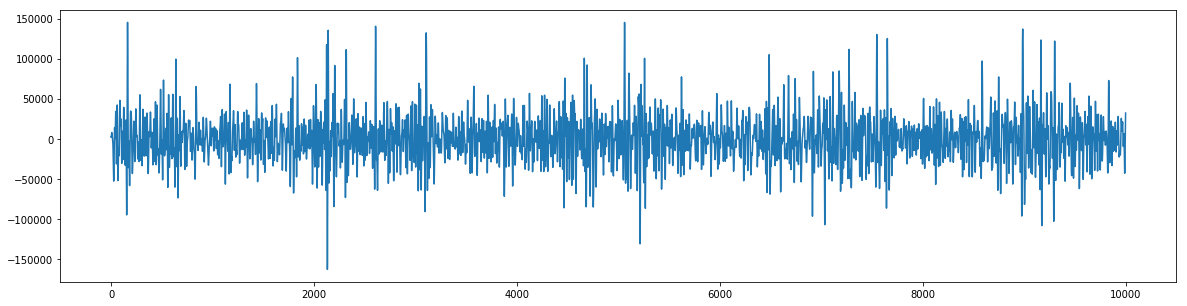

In [37]:
plt.figure(figsize=(20,5))
plt.plot(sig_data.flatten()[:10000])

In [41]:
np.savetxt('test_data.txt', sig_data.flatten(), fmt='%.3e')

In [40]:
sig_data.flatten()[:5]

array([ 2176.99145508,  1878.00561523,  2176.99145508,  3045.91943359,
        4316.60986328], dtype=float32)